# Chemical space analysis of small molecule drugs with RDKit and dimensionality reduction methods
This is a quick tutorial on chemical space analysis and visualization with RDKit and dimensionality reduction methods PCA and t-SNE (sklearn). Due to the high dimensionality of chemical fingerprints, we have to use dimensionality reduction methods in order to facilitate the plotting of chemical space. Two popular methods are:
  - [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) - Principal component analysis
  - [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - t-Distributed Stochastic Neighbor Embedding

We will use known drugs and try to see if there are differences between different classes of drugs in the projected chemical space.

@TAGS: #advanced #sklearn #PCA #t-SNE

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

Load the table of drugs (downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) )

In [5]:
!pwd

/home/lukas/work/web/scraper/utils


In [6]:
df = pd.read_csv('./chembl_drugs.txt.gz', sep='\t')

In [19]:
df.columns.tolist()

['PARENT_MOLREGNO',
 'CHEMBL_ID',
 'SYNONYMS',
 'DEVELOPMENT_PHASE',
 'RESEARCH_CODES',
 'APPLICANTS',
 'USAN_STEM',
 'USAN_STEM_DEFINITION',
 'USAN_STEM_SUBSTEM',
 'USAN_YEAR',
 'FIRST_APPROVAL',
 'ATC_CODE',
 'ATC_CODE_DESCRIPTION',
 'INDICATION_CLASS',
 'SC_PATENT_NO',
 'DRUG_TYPE',
 'RULE_OF_FIVE',
 'FIRST_IN_CLASS',
 'CHIRALITY',
 'PRODRUG',
 'ORAL',
 'PARENTERAL',
 'TOPICAL',
 'BLACK_BOX',
 'AVAILABILITY_TYPE',
 'WITHDRAWN_YEAR',
 'WITHDRAWN_COUNTRY',
 'WITHDRAWN_REASON',
 'CANONICAL_SMILES',
 'ROMol']

Keep only compounds with SMILES, [USAN stems](https://www.ama-assn.org/about-us/united-states-adopted-names-approved-stems), that respect [Ro5](https://en.wikipedia.org/wiki/Lipinski's_rule_of_five) and are on the market

In [8]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        df['USAN_STEM'].notnull() & # USAN stem
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [16]:
df.shape

(700, 30)

In [10]:
df

,PARENT_MOLREGNO,CHEMBL_ID,SYNONYMS,DEVELOPMENT_PHASE,RESEARCH_CODES,APPLICANTS,USAN_STEM,USAN_STEM_DEFINITION,USAN_STEM_SUBSTEM,USAN_YEAR,...,PRODRUG,ORAL,PARENTERAL,TOPICAL,BLACK_BOX,AVAILABILITY_TYPE,WITHDRAWN_YEAR,WITHDRAWN_COUNTRY,WITHDRAWN_REASON,CANONICAL_SMILES
0,675015,CHEMBL1201064,"Fluorometholone Acetate (FDA, USAN)",4,U-17323,Alcon Laboratories Inc,-olone,steroids (not prednisolone derivatives),-olone,1984.0,...,Y,N,N,Y,N,Prescription-only,NaN,NaN,NaN,C[C@H]1C[C@H]2[C@@H]3CC[C@](OC(=O)C)(C(=O)C)[C...
1,112655,CHEMBL1009,"Levodopa (BAN, FDA, INN, JAN, USAN, USP)",4,NaN,Shire Development Inc; Orion Pharma; Merck Sha...,-dopa,dopamine receptor agonists,-dopa,1969.0,...,N,Y,N,N,N,Prescription-only,NaN,NaN,NaN,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O
4,246,CHEMBL9,"Norfloxacin (BAN, FDA, INN, JAN, USAN, USP)",4,MK-366,Merck Research Laboratories Div Merck Co Inc,-oxacin,antibacterials (quinolone derivatives),-oxacin,1984.0,...,N,Y,N,Y,Y,Prescription-only,NaN,NaN,NaN,CCN1C=C(C(=O)O)C(=O)c2cc(F)c(cc12)N3CCNCC3
5,139014,CHEMBL1068,"Oxcarbazepine (BAN, FDA, INN, USAN)",4,GP-47680; KIN-493,Supernus Pharmaceuticals Inc; Novartis Pharmac...,-pin(e),tricyclic compounds,-pin(e),2002.0,...,Y,Y,N,N,Y,Prescription-only,NaN,NaN,NaN,NC(=O)N1c2ccccc2CC(=O)c3ccccc13
11,691867,CHEMBL1229517,"Vemurafenib (FDA, INN, USAN)",4,PLX-4032; RG-7204; Ro-5185426,Hoffmann La Roche Inc,-rafenib,raf kinase inhibitors,-rafenib,2010.0,...,N,Y,N,N,N,Prescription-only,NaN,NaN,NaN,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,675099,CHEMBL1201148,"Meprednisone (FDA, INN, USAN, USP)",4,SCH-4358,Schering Corp Sub Schering Plough Corp,-pred-,prednisone and prednisolone derivatives,-pred-,1965.0,...,N,Y,N,N,N,Discontinued,NaN,NaN,NaN,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...
11396,1285392,CHEMBL1963681,"Avanafil (FDA, INN, USAN)",4,TA-1790,Vivus Inc,-afil,PDE5 inhibitors,-afil,2000.0,...,N,Y,N,N,N,Prescription-only,NaN,NaN,NaN,COc1ccc(CNc2nc(ncc2C(=O)NCc3ncccn3)N4CCC[C@H]4...
11403,371655,CHEMBL1436,"Cefuroxime (BAN, INN, USAN, FDA); Cefuroxime S...",4,640/359,"Glaxo, England; Covis Pharma Sarl; B Braun Med...",cef-,cephalosporins,cef-,1984.0,...,N,N,Y,N,N,Prescription-only,NaN,NaN,NaN,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(=O)O...
11413,1380100,CHEMBL2107830,"Empagliflozin (FDA, INN, USAN)",4,NaN,Boehringer Ingelheim Pharmaceuticals Inc,-gliflozin,"phlorozin derivatives, phenolic glycosides",-gliflozin,2012.0,...,N,Y,N,N,N,Prescription-only,NaN,NaN,NaN,OC[C@H]1O[C@H]([C@H](O)[C@@H](O)[C@@H]1O)c2ccc...


Add molecule column

In [11]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')

In [14]:
df = df[~df['ROMol'].isnull()]

Check most common compound classees (based on USAN stem)

In [20]:
common_stems = df.groupby('USAN_STEM').size().sort_values()[-10:]
common_stems

USAN_STEM
-pin(e)    12
-tinib     12
-olone     12
-ium       14
-caine     15
-vir       15
-cillin    17
-oxacin    17
-olol      18
sulfa-     18
dtype: int64

In [21]:
stems = df.drop_duplicates(['USAN_STEM'])[df.drop_duplicates(['USAN_STEM'])['USAN_STEM'].isin(common_stems.index)][['USAN_STEM','USAN_STEM_DEFINITION']]
stems.index = stems['USAN_STEM']
stems['count'] = common_stems

In [22]:
stems

,USAN_STEM,USAN_STEM_DEFINITION,count
USAN_STEM,,,
-olone,-olone,steroids (not prednisolone derivatives),12
-oxacin,-oxacin,antibacterials (quinolone derivatives),17
-pin(e),-pin(e),tricyclic compounds,12
-tinib,-tinib,tyrosine kinase inhibitors,12
-caine,-caine,local anesthetics,15
sulfa-,sulfa-,antimicrobials (sulfonamides derivatives),18
-vir,-vir,antivirals: antivirals (acyclovir type),15
-ium,-ium,quaternary ammonium derivatives,14
-cillin,-cillin,penicillins,17


Helper functions

In [23]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn
    
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    
    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

Calculate fingerprints

In [24]:
df['FP'] = df['ROMol'].map(get_cfps)

[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerator
[15:55:41] DEPRECATION WARNING: please use MorganGenerat

Extract compounds that belong to 10 most common USAN stems

In [25]:
df_small = df[df['USAN_STEM'].isin(list(stems.index))].copy()

In [26]:
len(df_small)

150

### PCA analysis

In [27]:
from sklearn.decomposition import PCA

In [28]:
X = np.array([x.fp for x in df_small['FP']])

In [29]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

In [30]:
df_small['PC1'] = pca_drugs.T[0]
df_small['PC2'] = pca_drugs.T[1]
df_small['PC3'] = pca_drugs.T[2]

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot principal components

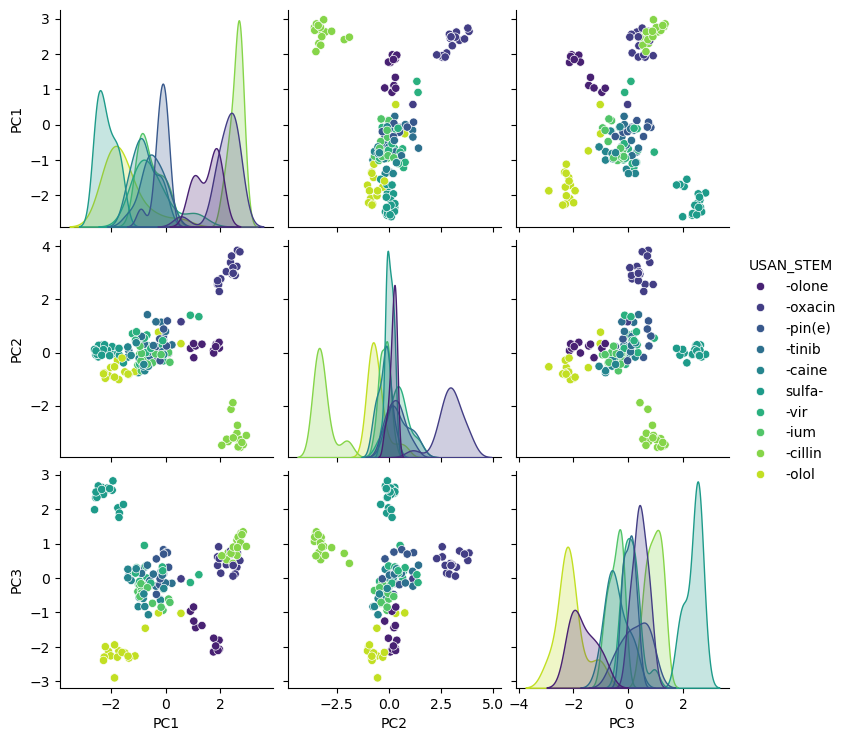

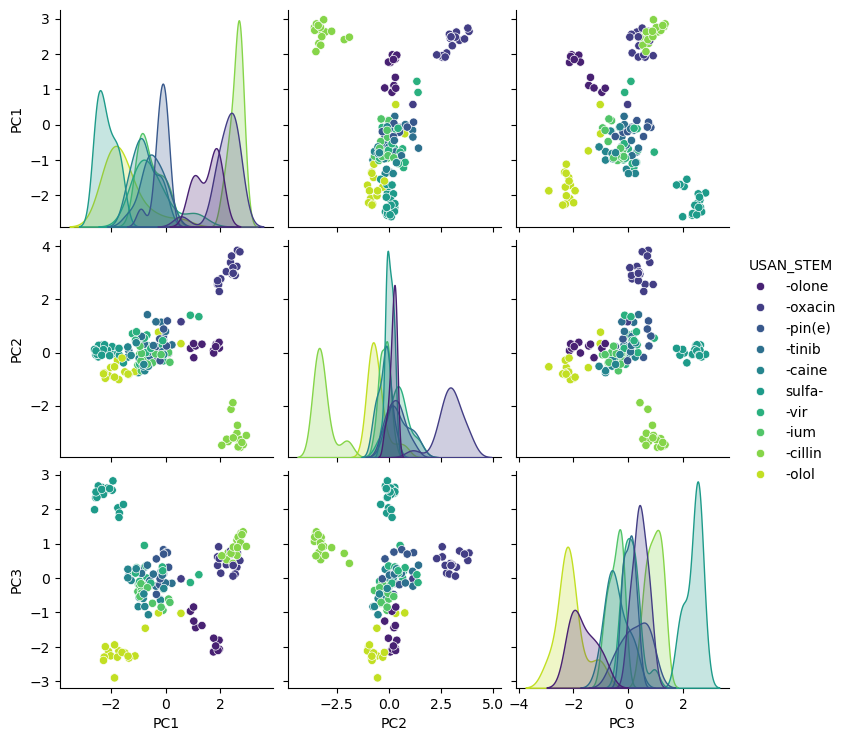

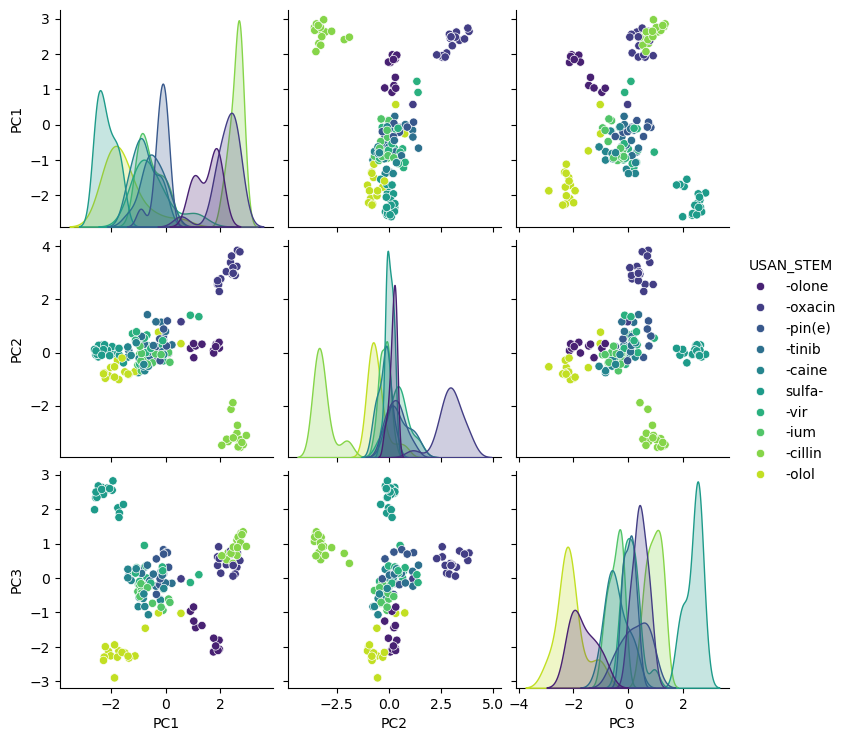

In [35]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['PC1', 'PC2', 'PC3'], palette='viridis')
plt.show()

### t-SNE
Note that [t-SNE is very sensitive to hyperparameter settings](http://distill.pub/2016/misread-tsne/).
#### Without PCA preprocessing

In [36]:
from sklearn.manifold import TSNE

In [37]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_drugs = model.fit_transform(X)

/home/lukas/anaconda3/envs/chem/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [38]:
df_small['TSNE_C1'] = tsne_drugs.T[0]
df_small['TSNE_C2'] = tsne_drugs.T[1]

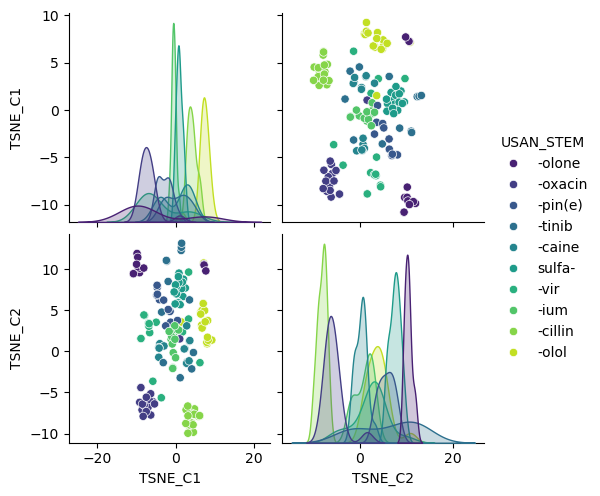

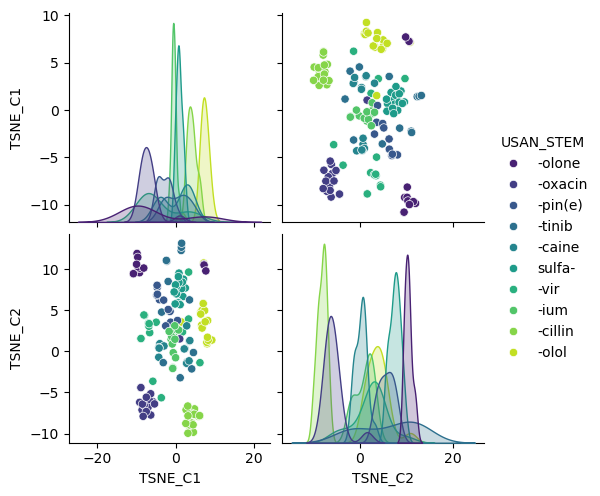

In [40]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis');
plt.show()

#### With PCA preprocessing
In case of high dimensionality data (like molecular fingerprints) it is recommended to reduce the number of dimensions with another method before proceeding with t-SNE.

In [41]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_pca_drugs = tsne_model.fit_transform(pca_model.fit_transform(X))

/home/lukas/anaconda3/envs/chem/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [42]:
df_small['TSNE_PCA_C1'] = tsne_pca_drugs.T[0]
df_small['TSNE_PCA_C2'] = tsne_pca_drugs.T[1]

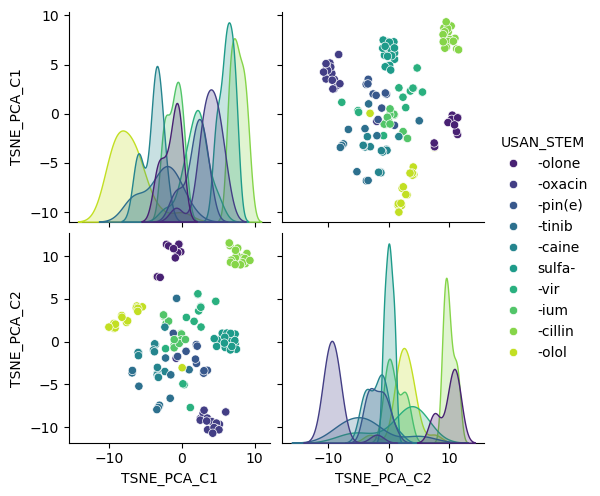

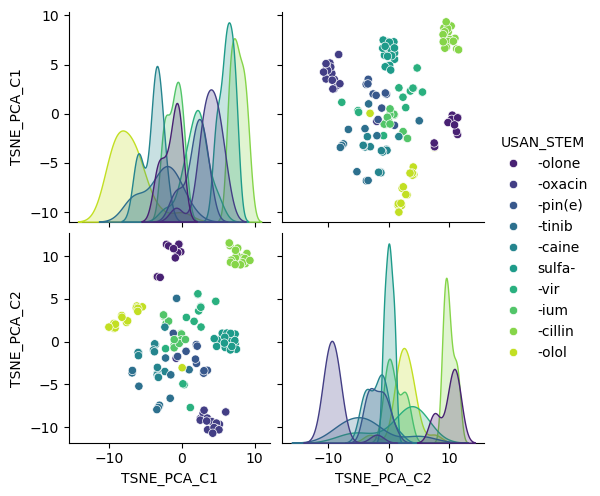

In [44]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_PCA_C1', 'TSNE_PCA_C2'], palette='viridis');
plt.show()

Tutorial author: Samo Turk, Jan. 2017